In [1]:
from pathlib import Path
import configparser
from psycopg2 import connect
import struct
import pandas as pd
from datetime import datetime

CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg'))) #Creates a path to your db.cfg file
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)


In [2]:
#find dates in database for backfilling:

sql = '''SELECT DISTINCT to_timestamp(timestamputc)::DATE, COUNT(1)
FROM vdsdata
GROUP BY 1
ORDER BY 1'''

with con: 
    dates_df = pd.read_sql(sql, con)

/opt/jupyterhub/lib64/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
print(dates_df.head(5))
print(dates_df.tail(5))
print("Total row count from vdsdata: {}".format(dates_df['count'].agg('sum')))

  to_timestamp   count
0   2021-08-14   15150
1   2021-08-15  485043
2   2021-08-16  485220
3   2021-08-17  485243
4   2021-08-18  486397
    to_timestamp    count
663   2023-06-08  1450215
664   2023-06-09  1356076
665   2023-06-10  1184917
666   2023-06-11   738971
667   2023-06-12    99356
Total row count from vdsdata: 763309676


In [4]:
#find days between min and max
min_date = min(dates_df['to_timestamp'])
max_date = max(dates_df['to_timestamp'])

(dates_df.shape[0] - 1) == (max_date - min_date).days

True

/opt/jupyterhub/lib64/python3.9/site-packages/IPython/core/interactiveshell.py


<AxesSubplot:>

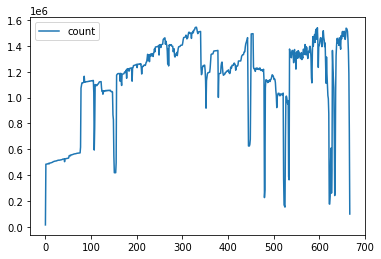

In [5]:
dates_df.plot()

Notes:
-760M rows!  
-Only back to 2021.  
-Data is available for current day.  
-It looks like the data is continuous with no days of zero data.
-Around 1-1.5M records per day, some dips.



In [ ]:
vdsconfig_sql = '''SELECT * FROM vdsconfig WHERE divisionid IN (2, 8001)'''
entity_sql = '''SELECT * FROM entitylocation WHERE divisionid IN (2, 8001)'''

with con: 
    vdsconfig = pd.read_sql(vdsconfig_sql, con)
    entitylocations = pd.read_sql(entity_sql, con)


In [11]:
date_start = '2023-05-17 00:00:00 EST5EDT'
date_end = '2023-05-18 00:00:00 EST5EDT'

sql = f'''SELECT 
    d.divisionid,
    d.vdsid,
    d.timestamputc,
    d.lanedata
FROM vdsdata AS d
WHERE 
    timestamputc >= extract(epoch from timestamptz '{date_start}')
    AND timestamputc < extract(epoch from timestamptz '{date_end}'); '''

#run queries
with con: 
    df = pd.read_sql(sql, con)

print(f"Number of rows: {df.shape[0]}")

/opt/jupyterhub/lib64/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Number of rows: 1422079


In [12]:

# Parse lane data
def parse_lane_data(laneData):
    result = []

    with memoryview(laneData) as mv:
        i = 0 #index within memoryview
        while i < len(mv):
            # Get lane
            lane = mv[i][0]

            # Get speed
            #Stored in km/h * 100. 65535 for null value. Convert 0 to null to maintain backward compatibility
            speed = struct.unpack('<H', mv[i + 1] + mv[i + 2])[0] #>H denotes stored in big-endian format (PostGreSQL uses big-endian)
            speedKmh = None if speed == 65535 or speed == 0 else speed / 100.0

            # Get volume
            #Stored in vehicles per hour. 65535 for null value.
            volume = struct.unpack('<H', mv[i + 3] + mv[i + 4])[0]
            volumeVehiclesPerHour = None if volume == 65535 else volume

            # Get occupancy
            #Stored in percent * 100. 65535 for null value.
            occupancy = struct.unpack('<H', mv[i + 5] + mv[i + 6])[0]
            occupancyPercent = None if occupancy == 65535 else occupancy / 100.0

            # Get volume by vehicle lengths - these columns are empty 
            #Each class stored in vehicles per hour. 65535 for null value.
            passengerVolume = struct.unpack('<H', mv[i + 7] + mv[i + 8])[0]
            volumePassengerVehiclesPerHour = None if passengerVolume == 65535 else passengerVolume
            singleUnitTrucksVolume = struct.unpack('<H', mv[i + 9] + mv[i + 10])[0]
            volumeSingleUnitTrucksPerHour = None if singleUnitTrucksVolume == 65535 else singleUnitTrucksVolume
            comboTrucksVolume = struct.unpack('<H', mv[i + 11] + mv[i + 12])[0]
            volumeComboTrucksPerHour = None if comboTrucksVolume == 65535 else comboTrucksVolume
            multiTrailerTrucksVolume = struct.unpack('<H', mv[i + 13] + mv[i + 14])[0]
            volumeMultiTrailerTrucksPerHour = None if multiTrailerTrucksVolume == 65535 else multiTrailerTrucksVolume

            # Increment i by 15 to move to the next lane
            i += 15

            result.append([lane, speedKmh, volumeVehiclesPerHour, occupancyPercent, volumePassengerVehiclesPerHour, volumeSingleUnitTrucksPerHour, volumeComboTrucksPerHour, volumeMultiTrailerTrucksPerHour])
            
    return result

In [13]:
import pytz

print(df.head(20))

#get number of lanes in the binary data stream for each row
#row_lengths = df['lanedata'].map(len)
#empty_rows = df[row_lengths == 0]
empty_rows = df[[len(x) == 0 for x in df['lanedata']]]

if empty_rows.empty is False:
    print(f'Rows with empty lanedata: {empty_rows.shape[0]}')
else: 
    print(f'No empty rows discarded.')

#drop empty rows
df_clean = df #.drop(empty_rows.index) #remove empty rows

UTC_to_EDTEST = lambda a: datetime.fromtimestamp(a, tz = pytz.timezone("EST5EDT"))

df_clean['datetime'] = df_clean['timestamputc'].map(UTC_to_EDTEST) #convert from integer to timestamp

floor_15 = lambda a: 60 * 15 * (a // (60 * 15)) #very fast 15min binning using integer dtype
df_clean['datetime_15min'] = df_clean['timestamputc'].map(floor_15).map(UTC_to_EDTEST) 



    divisionid    vdsid  timestamputc  \
0            2  5062220    1684296374   
1            2  2000382    1684296372   
2            2  2000381    1684296372   
3         8001  2008697    1684296901   
4         8001  2009783    1684296901   
5         8001  2010337    1684296901   
6         8001  2010345    1684296901   
7         8001  2075417    1684296901   
8         8001  2080333    1684296901   
9         8001  3034940    1684296901   
10        8001  3034941    1684296901   
11        8001  2008642    1684296901   
12        8001  2010988    1684296901   
13        8001  2011023    1684296901   
14        8001  2011039    1684296901   
15        8001  2011041    1684296901   
16        8001  2009075    1684296901   
17        8001  2010696    1684296901   
18        8001  4864735    1684296901   
19        8001  4864736    1684296901   

                                             lanedata  
0   [b'\x01', b'\xcf', b'\x05', b'\x0c', b'\x00', ...  
1   [b'\x01', b')', b'.', 

In [14]:

#parse each `lanedata` column entry 
lane_data = df_clean['lanedata'].map(parse_lane_data)
n_rows = lane_data.map(len)

#flatten the nested list structure
lane_data = [item for sublist in lane_data for item in sublist]

#convert list structure to df
cols = ['lane', 'speedKmh', 'volumeVehiclesPerHour', 'occupancyPercent', 'volumePassengerVehiclesPerHour', 'volumeSingleUnitTrucksPerHour', 'volumeComboTrucksPerHour', 'volumeMultiTrailerTrucksPerHour']
lane_data_df = pd.DataFrame(lane_data, columns = cols) 

#repeat original index based on number of rows in result as a join column
lane_data_df.set_index(df_clean.index.repeat(n_rows), inplace=True)

In [15]:
#join with other columns on index 
raw_20sec = df_clean[['divisionid', 'vdsid', 'datetime', 'datetime_15min']].join(lane_data_df)

print(raw_20sec.shape[0])

2014323


In [16]:
#aggregate from 20s hourly rate to 15 minute volume
#this method of aggregation assumes missing bins are zeros. 
def rate_to_volume(x): 
    return x.sum() / 4 / 45 

# /4 is for hourly to 15 minute volume.
# /45 is for 45 20sec bins per 15 minutes (assumes missing bins are zeros).

All volume columns besides 'volumeVehiclesPerHour' are blank. Rescu sensors do not separate by vehicle type.

In [17]:

raw_20sec[['volumeVehiclesPerHour',
           'volumePassengerVehiclesPerHour',
           'volumeSingleUnitTrucksPerHour',
           'volumeComboTrucksPerHour',
           'volumeMultiTrailerTrucksPerHour']].agg('sum')

volumeVehiclesPerHour              859270454.0
volumePassengerVehiclesPerHour               0
volumeSingleUnitTrucksPerHour                0
volumeComboTrucksPerHour                     0
volumeMultiTrailerTrucksPerHour              0
dtype: object

Wednesday - Friday traffic pattern.  
\# of bins has sporadic drops by 50%, but no corresponding volume dip. Probably some of the non-highway sensors dropping out.  
The peak highway volumes occur around 7am/6pm. Makes sense the highest throughput would not be at peak hours exactly but shoulder period.  


/opt/jupyterhub/lib64/python3.9/site-packages/IPython/core/interactiveshell.py


<AxesSubplot:xlabel='datetime_15min'>

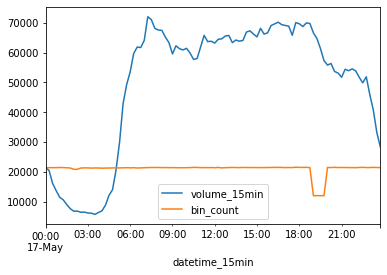

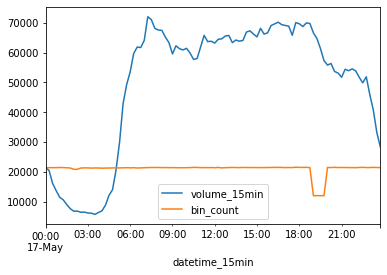

In [18]:
summary = raw_20sec.groupby('datetime_15min').agg(
        volume_15min = ('volumeVehiclesPerHour', rate_to_volume),
        bin_count = ('datetime_15min', 'count'))

summary.plot()

s1 = summary.index >= '2023-05-17 00:00:00'
s2 = summary.index < '2023-05-18 00:00:00'
summary[s1 & s2].plot()


,divisionid,vdsid,datetime,datetime_15min,lane,speedKmh,volumeVehiclesPerHour,occupancyPercent,volumePassengerVehiclesPerHour,volumeSingleUnitTrucksPerHour,volumeComboTrucksPerHour,volumeMultiTrailerTrucksPerHour
0,2,5062220,2023-05-17 00:06:14-04:00,2023-05-17 00:00:00-04:00,1.0,14.87,12.0,0.50,None,None,None,None
1,2,2000382,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,1.0,118.17,360.0,1.74,None,None,None,None
1,2,2000382,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,2.0,96.97,1080.0,7.08,None,None,None,None
1,2,2000382,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,3.0,105.33,1080.0,5.57,None,None,None,None
1,2,2000382,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,4.0,113.98,540.0,3.05,None,None,None,None
1,2,2000382,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,5.0,NaN,0.0,0.00,None,None,None,None
2,2,2000381,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,4.0,118.66,180.0,1.01,None,None,None,None
2,2,2000381,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,3.0,104.48,360.0,2.30,None,None,None,None
2,2,2000381,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,2.0,117.41,540.0,4.01,None,None,None,None
2,2,2000381,2023-05-17 00:06:12-04:00,2023-05-17 00:00:00-04:00,1.0,127.49,180.0,1.05,None,None,None,None


In [13]:

volumes_15min = raw_20sec.groupby(['vdsid', 'divisionid', 'datetime_15min']).agg(
        volume_15min = ('volumeVehiclesPerHour', rate_to_volume),
        bin_count = ('datetime_15min', 'size')).reset_index()

volumes_15min['volume_15min'] = [int(x) for x in volumes_15min['volume_15min']]

print(f"Total daily volume: {volumes_15min['volume_15min'].sum():.2f}")

Total daily volume: 14178425.00


In [16]:
volumes_15min[volumes_15min['divisionid'] == 2].to_csv('/home/gwolofs/rescu_itscentral/volumes_15min.csv')
detector_inventory.to_csv('/home/gwolofs/rescu_itscentral/detector_inventory.csv')

In [15]:
volumes_15min = pd.read_csv('/home/gwolofs/rescu_itscentral/volumes_15min.csv')
detector_inventory = pd.read_csv('/home/gwolofs/rescu_itscentral/detector_inventory.csv')


In [17]:

#look at sensor daily totals: 
with pd.option_context("display.max_rows", 1000): 
    print(volumes_15min.groupby(['vdsid']).agg(
            volume_15min = ('volume_15min', sum)).head(1000))


         volume_15min
vdsid                
3              144511
6               62948
9              128689
10             208762
11             207985
12             276422
13             193150
14             270518
16              94446
17             238701
18             207920
20                  0
21             103720
22             178518
23             258740
25             262395
26             211945
27             244676
28             183017
29             257166
30             184230
31             265407
32             198007
33             216458
34             145885
37             103243
39              64697
43                 79
44                  0
45             204143
52             163969
53             189508
54             246418
65               4944
67              51344
69              25725
72                  3
73              62433
74              52752
75              45982
77              62016
78              36326
79              63410
83        

In [8]:
volumes_merged = volumes_15min.merge(detector_inventory, right_on = 'vdsid', left_on = 'vdsid', how = 'left')
volumes_merged = volumes_merged[volumes_merged.starttimestamputc.isna() | 
                                ((volumes_merged.datetime_15min >= volumes_merged.starttimestamputc) & 
                                ((volumes_merged.datetime_15min <= volumes_merged.endtimestamputc) | 
                                 (volumes_merged.endtimestamputc.isna())))]

print(volumes_merged.head(10))


NameError: name 'volumes_15min' is not defined

In [ ]:
#only a few different rows?
print(volumes_merged['volume_15min'].sum())
print(volumes_15min['volume_15min'].sum())

14405461.383333333
14405478.783333333


In [ ]:
volumes_15min['date'] = pd.to_datetime(volumes_15min['datetime_15min']).dt.date
print(volumes_15min[['date', 'vdsid']].drop_duplicates().count())

volumes_merged['date'] = pd.to_datetime(volumes_merged['datetime_15min']).dt.date
print(volumes_merged[['date', 'vdsid']].drop_duplicates().count())

date     28992
vdsid    28992
dtype: int64
date     28992
vdsid    28992
dtype: int64


In [ ]:

print(f"Total volume: {volumes_merged['volume_15min'].sum():.2f}")

Total daily volume: 14405461.38


In [ ]:

#by_detector.to_csv('/home/gwolofs/rescu_itscentral/sample_data.csv')

#look at a single sensor (one which doesn't match total!)
#rawest data:
with pd.option_context("display.max_rows", 1000): 
    print(raw_20sec[raw_20sec['detector_id'] == 'de0041deg'])

#15 minute data: 
#overall difference for the day is 14. 
with pd.option_context("display.max_rows", 1000): 
    print(volumes_15min[volumes_15min['detector_id'] == 'de0041deg'].reset_index())


#are there both zeros and nulls? should we treat them differently?
total_raw_rows = empty_rows.shape[0] + lane_data.shape[0]
print(f"{100 * empty_rows.shape[0] / total_raw_rows:.3f}% rows have null lanedata.")



KeyError: 'detector_id'

In [ ]:
#distinct bins expected: 
bins_expected = raw_20sec[['vdsid', 'lane']].drop_duplicates().shape[0] * 24 * 60 * 3
print(f"{100 * raw_20sec.shape[0] / bins_expected:.3f}% of expected bins present based on # detectors and lanes.")


13.621% of expected bins present based on # detectors and lanes.


In [ ]:
detector_inventory

KeyError: 'detector_id'

In [ ]:
#bins expected but only highways & not ramps
only_highways = raw_20sec[[x[0] == 'D' and x[-1] != 'R' for x in raw_20sec['detector_id']]]
bins_expected = only_highways[['detector_id', 'lane']].drop_duplicates().shape[0] * 24 * 60 * 3
print(f"{100 * only_highways.shape[0] / bins_expected:.3f}% of expected bins present based on # detectors and lanes for only highways (not including ramps).")



In [ ]:
only_highways = raw_20sec[[x[0] == 'D' and x[-1] != 'R' for x in raw_20sec['detector_id']]]
bins_expected = only_highways[['detector_id', 'lane']].drop_duplicates().shape[0] * 24 * 60 * 3
print(f"{100 * only_highways.shape[0] / bins_expected:.3f}% of expected bins present based on # detectors and lanes for only highways (not including ramps).")



In [11]:
#divisionid==8001 are signal loop detectors and recorded an average volume of 8. Exclude. 
#almost half of all records are from these detectors.
detectors_8001 = detector_inventory[['detector_id', 'divisionid', ]][detector_inventory['divisionid'] == 8001]

volumes_merged = volumes_15min.merge(detectors_8001, right_on = 'vdsid', left_on = 'vdsid', how = 'left')
volumes_merged = volumes_merged[volumes_merged.starttimestamputc.isna() | 
                                ((volumes_merged.datetime_15min >= volumes_merged.starttimestamputc) & 
                                ((volumes_merged.datetime_15min <= volumes_merged.endtimestamputc) | 
                                 (volumes_merged.endtimestamputc.isna())))]


volumes_merged.agg({'sum', 'count', 'mean'})
#detectors_8001 = by_detector.merge(detectors_8001, left_index= True, right_on= 'detector_id')
#detectors_8001['volume_15min'].agg({'sum', 'count', 'mean'})



NameError: name 'volumes_15min' is not defined

In [ ]:
detector_inventory['detector_id'] = str(detector_inventory['detector_id'])
volumes_merged['detector_id'] = str(volumes_merged['detector_id'])

In [ ]:
#28 BlueCity.ai (BCT) sensors installed at Yonge and Church. Avg volume of 2. Exclude.
detectors_BCT = volumes_merged[[x[0:3] == 'BCT' for x in volumes_merged['detector_id']]]
print(detectors_BCT.head(10))


Empty DataFrame
Columns: [vdsid, datetime_15min, volume_15min, bin_count, divisionid, detector_id, starttimestamputc, endtimestamputc, lanes, hasgpsunit, managementurl, description, fssdivisionid, fssid, rtmsfromzone, rtmstozone, detectortype, createdby, createdbystaffid, signalid, signaldivisionid, movement, entitytype, locationtimestamputc, latitude, longitude, altitudemetersasl, headingdegrees, speedkmh, numsatellites, dilutionofprecision, mainroadid, crossroadid, secondcrossroadid, mainroadname, crossroadname, secondcrossroadname, streetnumber, offsetdistancemeters, offsetdirectiondegrees, locationsource, locationdescriptionoverwrite, typeof]
Index: []

[0 rows x 43 columns]


In [ ]:

detectors_BCT = volumes_merged.merge(detectors_BCT, left_index= True, right_on= 'detector_id')
detectors_BCT['volume_15min'].agg({'sum', 'count', 'mean'})

#by_detector.merge(detector_inventory[['divisionid', 'detector_id', 'starttimestamputc', 'endtimestamputc']], right_on = 'detector_id', left_on = 'detector_id')

#    AND to_timestamp(d.timestamputc) >= c.starttimestamputc
#    AND (
#        to_timestamp(d.timestamputc) <= c.endtimestamputc
#        OR c.endtimestamputc IS NULL) --no end date


In [ ]:

#what about nulls?
#remove_empt
#should we stop using detector_id as unique id?
